In [112]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models, utils
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Import to turn of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


In [3]:
# Trasform for data augmentation
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(0, shear=15, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# Importing the dataset
training = datasets.ImageFolder('Data/Training/', transform=transform)
testing = datasets.ImageFolder('Data/Testing/', transform=transforms.Compose([
                                    transforms.Resize((256,256)),transforms.ToTensor()]))

# Splitting the data into 0.8 training and 0.2 testing sets
train_size = int(0.8 * len(training))
test_size = len(training) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(training, [train_size, test_size])

# Making a validation set from the training set
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Creating a DataLoader for the training and testing sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(testing, batch_size=32, shuffle=True)

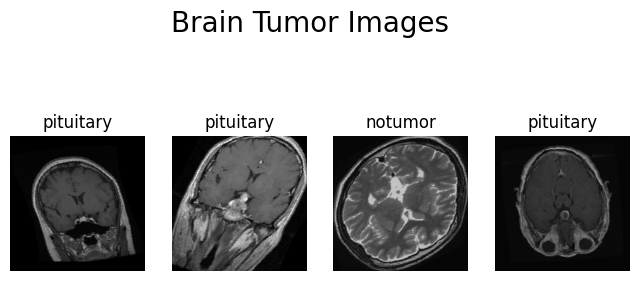

In [4]:
# Creating a dictionary to map the labels to the brain tumor images
classes = training.classes

# Creating a function to show a batch of images with labels
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(figsize=(8, 4), ncols=4)
    for i in range(4):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(classes[labels[i]])
        ax.axis('off')
    # Put main title to the figure
    plt.suptitle('Brain Tumor Images', fontsize=20)
    plt.show()

# Showing a batch of images
show_batch_images(train_loader)

In [5]:
# Making a class to use a pretrained EfficientNet model for Image Classification
# the input size is 3x256x256
class EfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNet, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        # self.model._fc = nn.Linear(in_features=1280, out_features=num_classes, bias=True)
        self.model._fc = nn.Sequential(
            nn.Linear(in_features=1280, out_features=512, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=num_classes, bias=True),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.model(x)
    
# Creating an instance of the EfficientNet class
model = EfficientNet(num_classes=4)

# Show model summary
model

# Moving the model to the device
model.to(device)

# Creating an optimizer and a loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [7]:
# Class for early stopping implementation
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [8]:
# Creating a function to train the model and calculate F1, precision, and recall
def train(model, optimizer, criterion, train_loader, val_loader, epochs=100, early_stopping=None):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    f1_scores = []
    precision_scores = []
    recall_scores = []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        predictions = []
        ground_truth = []
        for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
            ground_truth.extend(labels.tolist())

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        val_predictions = []
        val_ground_truth = []
        with torch.no_grad():
            for i, (images, labels) in tqdm(enumerate(val_loader), total=len(val_loader)):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_predictions.extend(predicted.tolist())
                val_ground_truth.extend(labels.tolist())

        val_loss = running_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Calculate F1, precision, and recall
        train_f1 = f1_score(ground_truth, predictions, average='weighted')
        train_precision = precision_score(ground_truth, predictions, average='weighted')
        train_recall = recall_score(ground_truth, predictions, average='weighted')
        f1_scores.append(train_f1)
        precision_scores.append(train_precision)
        recall_scores.append(train_recall)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
        print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")
        print(f"Train F1 Score: {train_f1:.4f}")
        print(f"Precision: {train_precision:.4f}")
        print(f"Recall: {train_recall:.4f}")

        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return train_losses, val_losses, train_accs, val_accs, f1_scores, precision_scores, recall_scores

# Create an instance of the custom early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

# Train the model with early stopping and calculate F1, precision, and recall
train_losses, val_losses, train_accs, val_accs, f1_scores, precision_scores, recall_scores = train(model, optimizer, criterion, train_loader, val_loader, epochs=100, early_stopping=early_stopping)

100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 1/100
Train loss: 1.7729, Train acc: 0.6948
Val loss: 0.3280, Val acc: 0.8972
Train F1 Score: 0.7586
Precision: 0.8354
Recall: 0.6948
Validation loss decreased (inf --> 0.328016).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


Epoch 2/100
Train loss: 0.3070, Train acc: 0.8983
Val loss: 0.1659, Val acc: 0.9497
Train F1 Score: 0.8983
Precision: 0.8984
Recall: 0.8983
Validation loss decreased (0.328016 --> 0.165925).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


Epoch 3/100
Train loss: 0.2118, Train acc: 0.9246
Val loss: 0.1332, Val acc: 0.9650
Train F1 Score: 0.9246
Precision: 0.9246
Recall: 0.9246
Validation loss decreased (0.165925 --> 0.133166).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


Epoch 4/100
Train loss: 0.1514, Train acc: 0.9467
Val loss: 0.1493, Val acc: 0.9387
Train F1 Score: 0.9467
Precision: 0.9467
Recall: 0.9467
EarlyStopping counter: 1 out of 3


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


Epoch 5/100
Train loss: 0.1304, Train acc: 0.9555
Val loss: 0.1284, Val acc: 0.9475
Train F1 Score: 0.9556
Precision: 0.9557
Recall: 0.9555
Validation loss decreased (0.133166 --> 0.128441).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


Epoch 6/100
Train loss: 0.1236, Train acc: 0.9594
Val loss: 0.1246, Val acc: 0.9584
Train F1 Score: 0.9594
Precision: 0.9594
Recall: 0.9594
Validation loss decreased (0.128441 --> 0.124644).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


Epoch 7/100
Train loss: 0.1025, Train acc: 0.9652
Val loss: 0.0765, Val acc: 0.9672
Train F1 Score: 0.9652
Precision: 0.9652
Recall: 0.9652
Validation loss decreased (0.124644 --> 0.076501).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Epoch 8/100
Train loss: 0.0787, Train acc: 0.9728
Val loss: 0.0819, Val acc: 0.9737
Train F1 Score: 0.9727
Precision: 0.9727
Recall: 0.9728
EarlyStopping counter: 1 out of 3


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


Epoch 9/100
Train loss: 0.0721, Train acc: 0.9718
Val loss: 0.0547, Val acc: 0.9781
Train F1 Score: 0.9718
Precision: 0.9719
Recall: 0.9718
Validation loss decreased (0.076501 --> 0.054714).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


Epoch 10/100
Train loss: 0.0689, Train acc: 0.9754
Val loss: 0.0539, Val acc: 0.9781
Train F1 Score: 0.9754
Precision: 0.9755
Recall: 0.9754
Validation loss decreased (0.054714 --> 0.053854).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


Epoch 11/100
Train loss: 0.0602, Train acc: 0.9784
Val loss: 0.0666, Val acc: 0.9825
Train F1 Score: 0.9783
Precision: 0.9783
Recall: 0.9784
EarlyStopping counter: 1 out of 3


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Epoch 12/100
Train loss: 0.0558, Train acc: 0.9818
Val loss: 0.0509, Val acc: 0.9781
Train F1 Score: 0.9818
Precision: 0.9818
Recall: 0.9818
Validation loss decreased (0.053854 --> 0.050882).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


Epoch 13/100
Train loss: 0.0529, Train acc: 0.9820
Val loss: 0.0969, Val acc: 0.9694
Train F1 Score: 0.9820
Precision: 0.9821
Recall: 0.9820
EarlyStopping counter: 1 out of 3


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


Epoch 14/100
Train loss: 0.0453, Train acc: 0.9844
Val loss: 0.0601, Val acc: 0.9803
Train F1 Score: 0.9844
Precision: 0.9844
Recall: 0.9844
EarlyStopping counter: 2 out of 3


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


Epoch 15/100
Train loss: 0.0450, Train acc: 0.9839
Val loss: 0.0426, Val acc: 0.9847
Train F1 Score: 0.9839
Precision: 0.9839
Recall: 0.9839
Validation loss decreased (0.050882 --> 0.042616).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


Epoch 16/100
Train loss: 0.0366, Train acc: 0.9888
Val loss: 0.0921, Val acc: 0.9694
Train F1 Score: 0.9888
Precision: 0.9888
Recall: 0.9888
EarlyStopping counter: 1 out of 3


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


Epoch 17/100
Train loss: 0.0394, Train acc: 0.9869
Val loss: 0.0465, Val acc: 0.9847
Train F1 Score: 0.9869
Precision: 0.9869
Recall: 0.9869
EarlyStopping counter: 2 out of 3


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


Epoch 18/100
Train loss: 0.0286, Train acc: 0.9905
Val loss: 0.0402, Val acc: 0.9869
Train F1 Score: 0.9905
Precision: 0.9905
Recall: 0.9905
Validation loss decreased (0.042616 --> 0.040213).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


Epoch 19/100
Train loss: 0.0298, Train acc: 0.9893
Val loss: 0.0347, Val acc: 0.9847
Train F1 Score: 0.9893
Precision: 0.9893
Recall: 0.9893
Validation loss decreased (0.040213 --> 0.034732).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


Epoch 20/100
Train loss: 0.0292, Train acc: 0.9912
Val loss: 0.0732, Val acc: 0.9759
Train F1 Score: 0.9912
Precision: 0.9913
Recall: 0.9912
EarlyStopping counter: 1 out of 3


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


Epoch 21/100
Train loss: 0.0295, Train acc: 0.9898
Val loss: 0.0632, Val acc: 0.9912
Train F1 Score: 0.9898
Precision: 0.9898
Recall: 0.9898
EarlyStopping counter: 2 out of 3


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]

Epoch 22/100
Train loss: 0.0248, Train acc: 0.9934
Val loss: 0.0393, Val acc: 0.9847
Train F1 Score: 0.9934
Precision: 0.9934
Recall: 0.9934
EarlyStopping counter: 3 out of 3
Early stopping


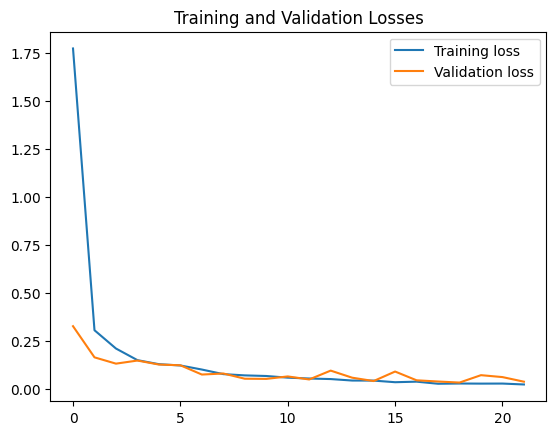

In [134]:
# Plot the training and testing losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

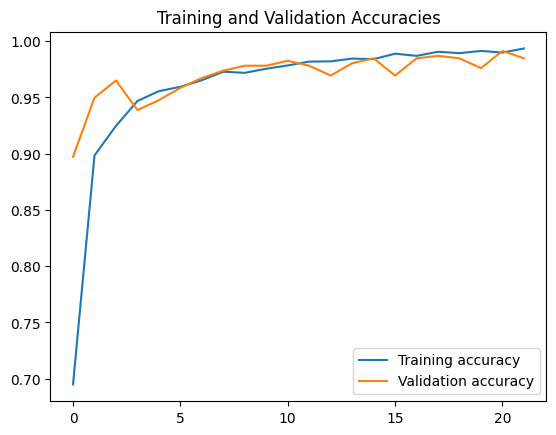

In [135]:
# Plot the training and testing accuracies
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

In [125]:
# Load the best model so far
best_model = EfficientNet(num_classes=4)
best_model.load_state_dict(torch.load('checkpoint.pt'))
best_model.to(device)
best_model.eval()

# Variables to store predictions and labels
correct = 0
total = 0
images_list = []
labels_list = []
preds_list = []
certainty_list = []

# Testing the best model on the test set
with torch.no_grad():
    for i, (images, labels) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Calculate certainty (probability)
        certainty = torch.softmax(outputs, dim=1)  # Softmax for certainty
        max_certainty, predicted_certainty = certainty.max(dim=1)

        images_list.append(images)
        labels_list.append(labels)
        preds_list.extend(predicted.cpu().numpy())  # Store predicted labels
        certainty_list.extend(max_certainty.cpu().numpy())  # Store certainty

# Calculate the accuracy, F1, precision, and recall on the test set
test_labels = [label.item() for labels in labels_list for label in labels]

test_acc = correct / total
test_f1 = f1_score(test_labels, preds_list, average='weighted')
test_precision = precision_score(test_labels, preds_list, average='weighted')
test_recall = recall_score(test_labels, preds_list, average='weighted')

print(f"Test acc: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Generate classification report
class_names = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]  # Replace with your class names
classification_rep = classification_report(test_labels, preds_list, target_names=class_names)
print("Classification Report:")
print(classification_rep)

# # Display the certainty for each prediction
# print("Certainty for each prediction:")
# for i in range(len(test_labels)):
#     label = class_names[test_labels[i]]
#     predicted = class_names[preds_list[i]]
#     certainty = certainty_list[i]
#     print(f"Actual: {label}, Predicted: {predicted}, Certainty: {certainty*100:.2f}")

100%|██████████| 41/41 [00:19<00:00,  2.13it/s]

Test acc: 0.9878
Test F1 Score: 0.9878
Test Precision: 0.9879
Test Recall: 0.9878
Classification Report:
              precision    recall  f1-score   support

      Glioma       0.99      0.97      0.98       300
  Meningioma       0.97      0.99      0.98       306
    No Tumor       1.00      1.00      1.00       405
   Pituitary       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



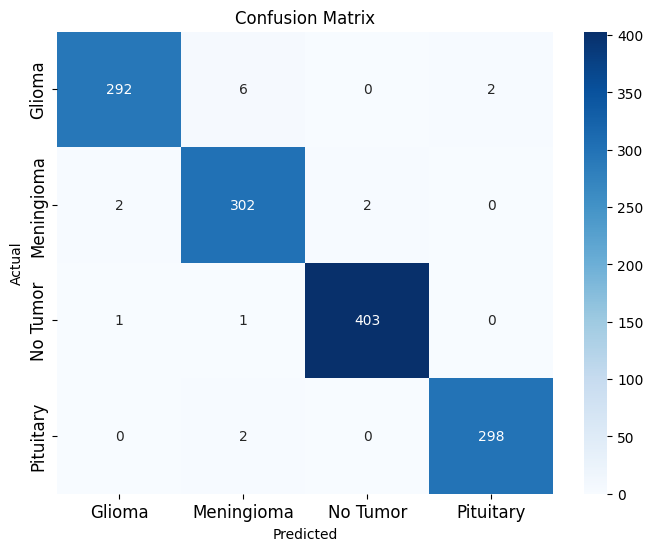

In [126]:
# Plot the confusion matrix with the numbers on each cell
cm = confusion_matrix(test_labels, preds_list)

# Define class names and create a DataFrame for the confusion matrix
class_names = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(np.arange(4) + 0.5, class_names, fontsize=12)
plt.yticks(np.arange(4)+ 0.5, class_names, fontsize=12)
plt.show()

In [127]:
# Showing images with labels, predictions
def show_images(batch, images_list = images_list, labels_list = labels_list, preds_list = preds_list):
    """
    Function to show a batch of 32 images with the real and predicted labels
    in parenthesis is a percentage of certainty for the prediction

    batch: batch number to show (from 0 to 32)
    images_list: list of images from the test set
    labels_list: list of labels from the test set
    preds_list: list of predictions from the test set
    """
    fig, axes = plt.subplots(figsize=(16, 28), nrows=8, ncols=4)
    sentinel = 0
    for i in range(8):
        for j in range(4):
            ax = axes[i][j]
            ax.imshow(images_list[batch][sentinel].permute(1, 2, 0).cpu().numpy())
            ax.set_title(f"Label: {classes[int(labels_list[batch][sentinel])]},\n" +\
                        f"Prediction: {classes[preds_list[batch*32:batch*32+32][sentinel]]} "+\
                        f"({certainty_list[batch*32:batch*32+32][sentinel]*100:.2f}%)")
            sentinel += 1
    # Hide the axis for exery axes
    for ax in axes.flatten():
        ax.axis('off')
    plt.show()

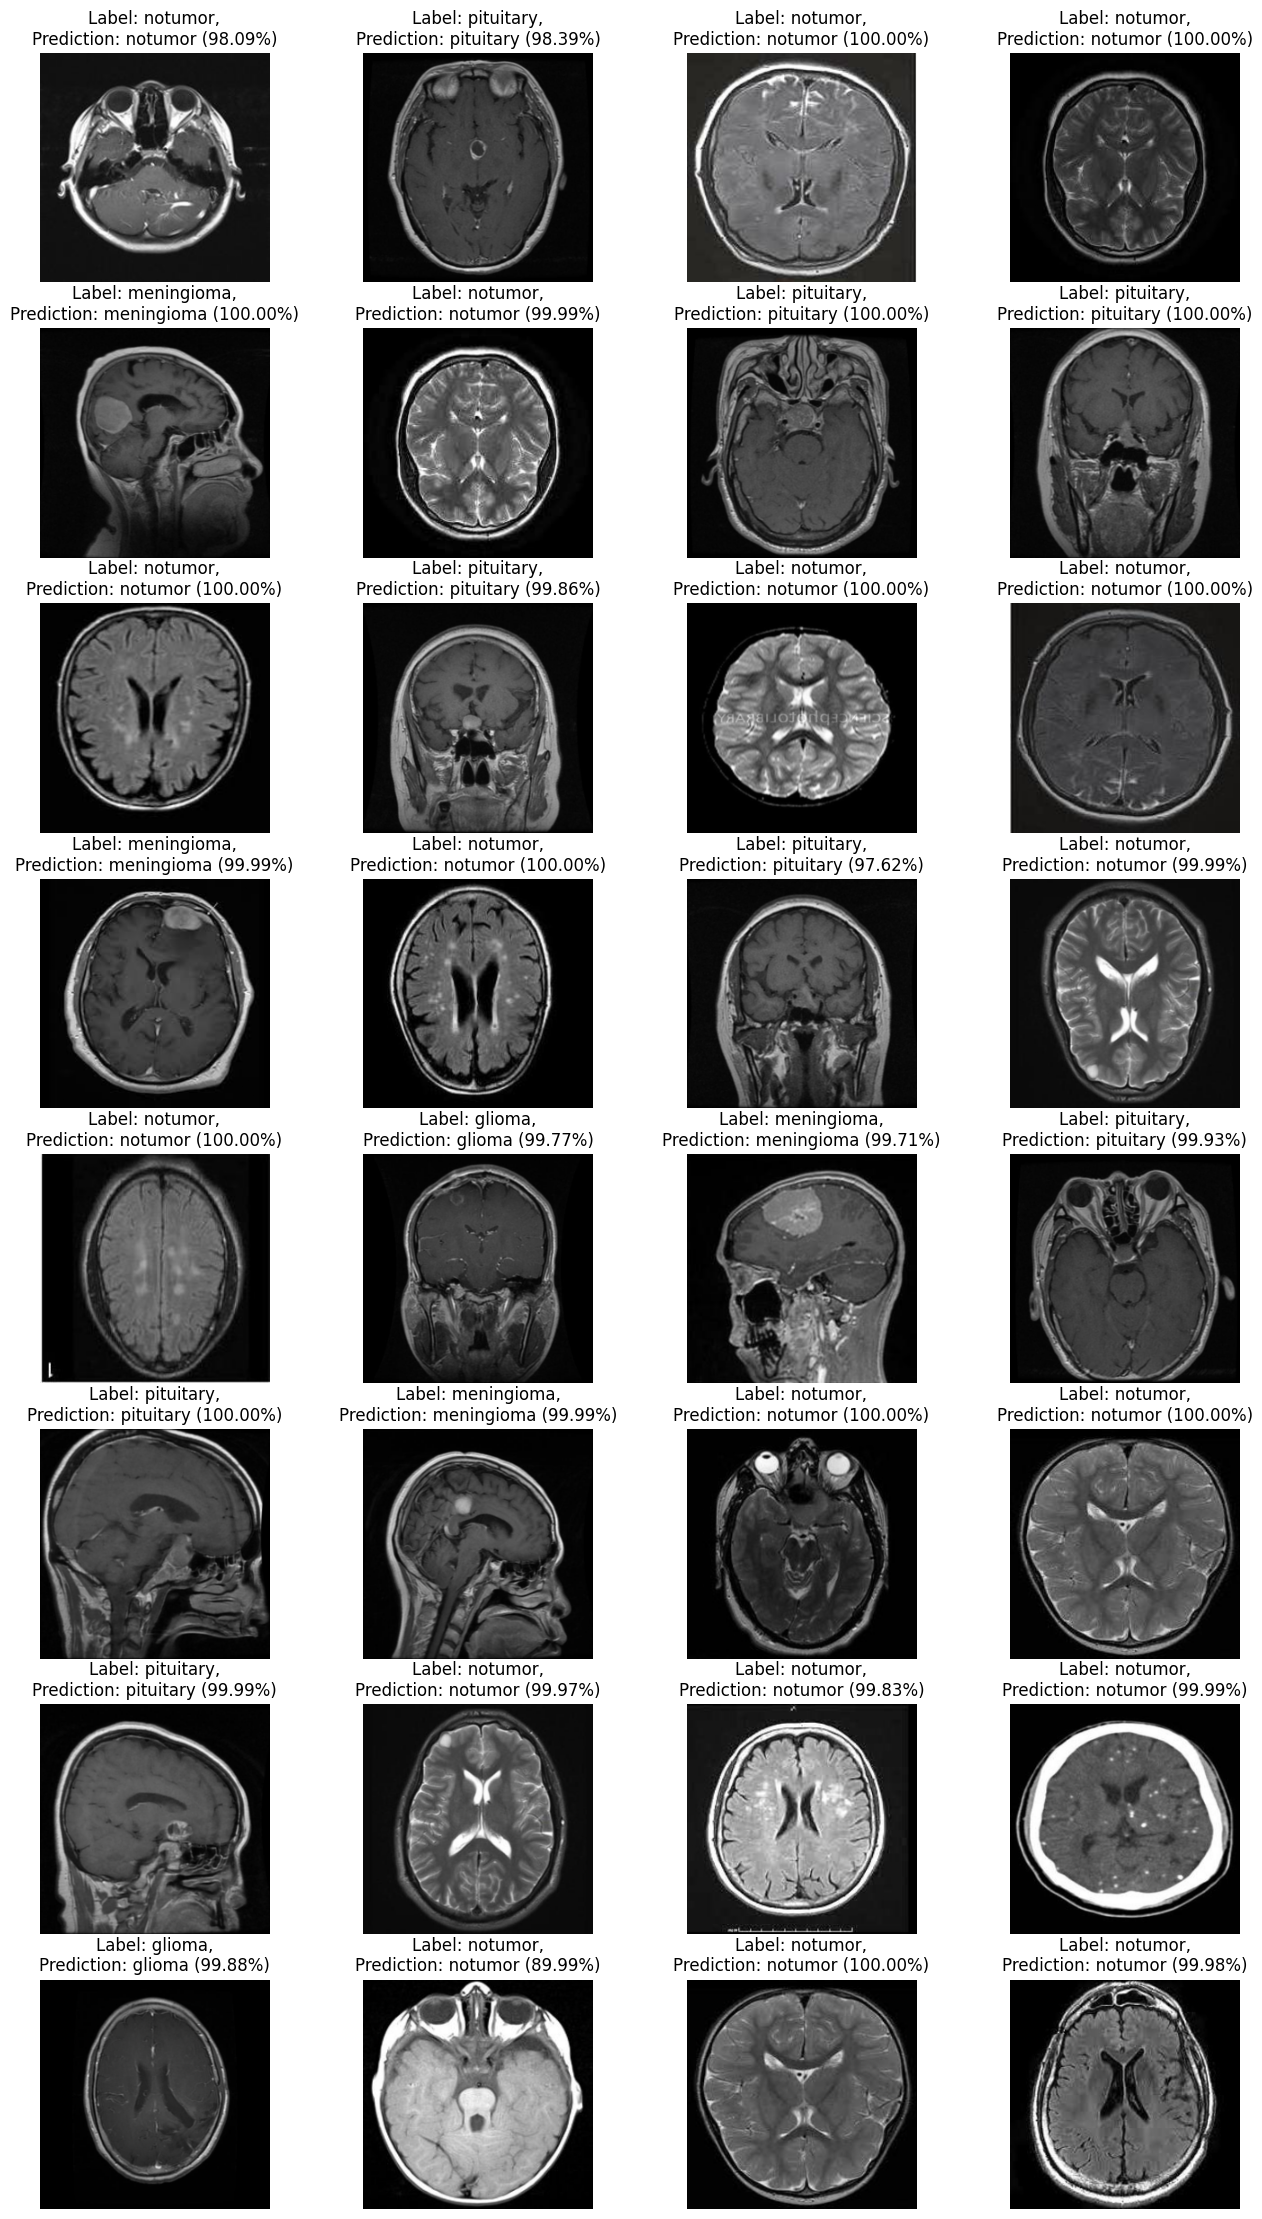

In [136]:
show_images(0)